In [1]:
# torch version = 2.3.1
# torchvision version = 0.18.1
# numpy version = 1.26.4

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
# import and normalize data

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure the images are in greyscale
    transforms.Resize((128, 128)),  
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize with mean and std for greyscale
])

train_dataset = torchvision.datasets.ImageFolder(root='./train', transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root='./test', transform=transform)


In [3]:
# check data shape
from collections import Counter
# Count the number of samples per class in the training set
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]
train_counter = Counter(train_labels)

# Count the number of samples per class in the test set
test_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
test_counter = Counter(test_labels)

classes = train_dataset.classes

# Print the distribution
print("Training set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {train_counter[i]}')

print("\nTest set class distribution:")
for i, class_name in enumerate(classes):
    print(f'{class_name:5s}: {test_counter[i]}')

Training set class distribution:
anger: 2466
contempt: 165
disgust: 191
fear : 652
happiness: 7528
neutral: 10308
sadness: 3514
surprise: 3562

Test set class distribution:
anger: 644
contempt: 51
disgust: 57
fear : 167
happiness: 1827
neutral: 2597
sadness: 856
surprise: 900


In [4]:
from torch.utils.data import DataLoader, WeightedRandomSampler


# given the the distribution of the train set is not balanced, we will use a weighted sampler
total_samples = len(train_dataset)

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)


# Calculate class weights based on the training set distribution
class_weights = {class_id: total_samples / count for class_id, count in train_counter.items()}
class_weights_list = [class_weights[label] for label in train_labels]
print(class_weights)
print(len(class_weights_list))

# Create a WeightedRandomSampler
sampler = WeightedRandomSampler(class_weights_list, len(class_weights_list), replacement=True, )

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

{0: 11.510948905109489, 1: 172.03636363636363, 2: 148.61780104712042, 3: 43.53680981595092, 4: 3.770722635494155, 5: 2.7537834691501746, 6: 8.077973819009676, 7: 7.969118472768108}
28386


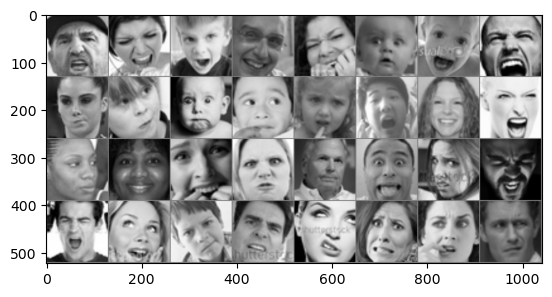

In [5]:
# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [7]:
# define train and validation as a funcnion

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10):
    model = model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        avg = running_loss / len(train_loader)
        train_losses.append(avg)
        train_accuracies.append(100 * correct / total)

        # Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():  
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_losses.append(running_loss / len(test_loader))
        val_accuracies.append(100 * correct / total)

        print(f'Epoch {epoch + 1}/{num_epochs}, train Loss: {train_losses[-1]:.4f}, train Acc: {train_accuracies[-1]:.2f}%, validation Loss: {val_losses[-1]:.4f}, validation Acc: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels


In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# plot training and validation loss
# Plotting the results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 5))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion matrix
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)

    # Plot confusion matrix
    disp.plot(cmap=plt.cm.Blues)
    plt.show()


In [8]:
# Defining base training hyper parameters 
num_classes = 8 
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
wd = 0.001
num_epochs = 20

In [9]:

# implementing the tiny VGG model
class TinyVGG3(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG3, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 2.1773, train Acc: 19.65%, validation Loss: 1.9313, validation Acc: 17.86%
Epoch 2/20, train Loss: 1.7400, train Acc: 30.73%, validation Loss: 1.8091, validation Acc: 31.37%
Epoch 3/20, train Loss: 1.4995, train Acc: 41.64%, validation Loss: 1.5418, validation Acc: 42.17%
Epoch 4/20, train Loss: 1.2363, train Acc: 52.62%, validation Loss: 1.3315, validation Acc: 48.98%
Epoch 5/20, train Loss: 1.0167, train Acc: 61.59%, validation Loss: 1.2712, validation Acc: 52.71%
Epoch 6/20, train Loss: 0.8556, train Acc: 67.92%, validation Loss: 1.2696, validation Acc: 49.20%
Epoch 7/20, train Loss: 0.7460, train Acc: 72.60%, validation Loss: 1.1263, validation Acc: 59.06%
Epoch 8/20, train Loss: 0.6541, train Acc: 75.75%, validation Loss: 1.0421, validation Acc: 61.60%
Epoch 9/20, train Loss: 0.5791, train Acc: 79.11%, validation Loss: 1.0452, validation Acc: 62.46%
Epoch 10/20, train Loss: 0.5323, train Acc: 80.87%, validation Loss: 1.0891, validation Acc: 62.90%
Epoch 11/

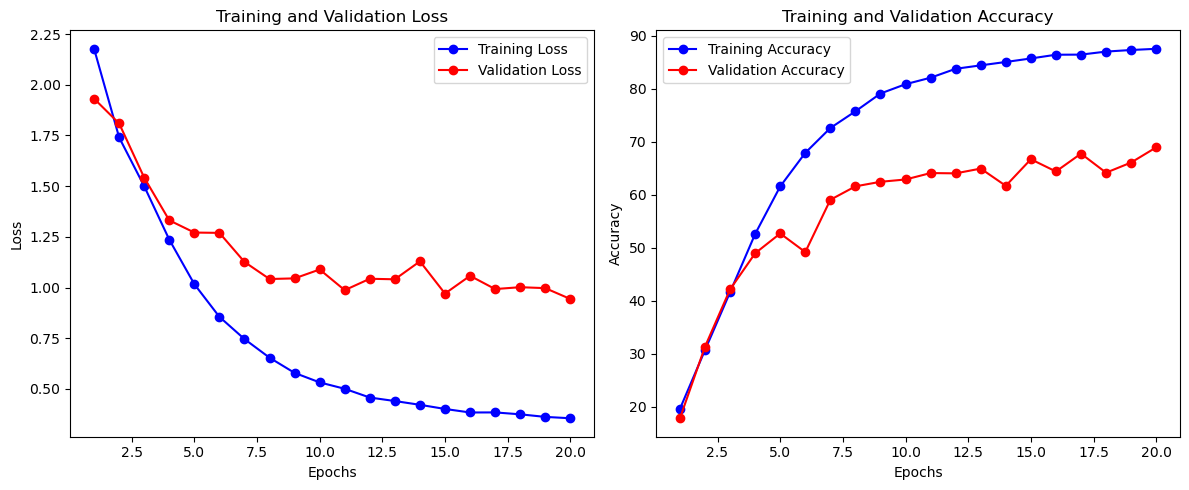

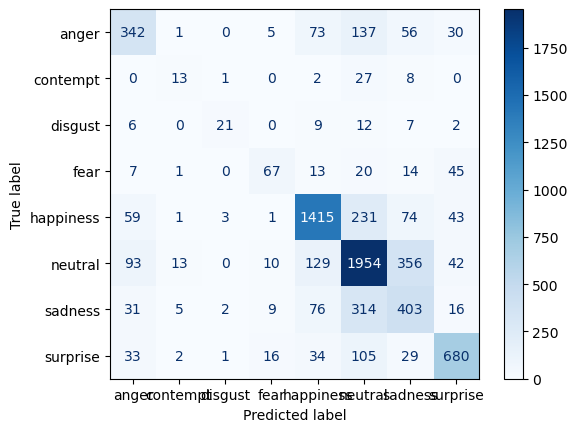

In [10]:

tiny_vgg = TinyVGG3(num_classes=num_classes)
optimizer = optim.Adam(tiny_vgg.parameters(), lr=learning_rate,weight_decay=wd)


train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(tiny_vgg,train_loader, test_loader,criterion, optimizer, num_epochs)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, num_epochs, all_preds, all_labels)


In [11]:
# implementing the tiny VGG with 4 convolutional layer blocks 
class TinyVGG4(nn.Module):
    def __init__(self, num_classes=8):
        super(TinyVGG4, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 2.2038, train Acc: 15.14%, validation Loss: 2.0405, validation Acc: 7.03%
Epoch 2/20, train Loss: 1.9850, train Acc: 20.41%, validation Loss: 1.9450, validation Acc: 20.96%
Epoch 3/20, train Loss: 1.9905, train Acc: 20.01%, validation Loss: 1.9296, validation Acc: 20.26%
Epoch 4/20, train Loss: 1.6094, train Acc: 39.32%, validation Loss: 1.4723, validation Acc: 43.26%
Epoch 5/20, train Loss: 1.1589, train Acc: 57.08%, validation Loss: 1.1760, validation Acc: 54.82%
Epoch 6/20, train Loss: 0.8758, train Acc: 67.78%, validation Loss: 1.0798, validation Acc: 54.85%
Epoch 7/20, train Loss: 0.7386, train Acc: 72.67%, validation Loss: 1.0373, validation Acc: 60.88%
Epoch 8/20, train Loss: 0.6344, train Acc: 77.11%, validation Loss: 0.9514, validation Acc: 64.54%
Epoch 9/20, train Loss: 0.5694, train Acc: 79.35%, validation Loss: 0.9177, validation Acc: 66.53%
Epoch 10/20, train Loss: 0.5175, train Acc: 81.29%, validation Loss: 1.0355, validation Acc: 62.78%
Epoch 11/2

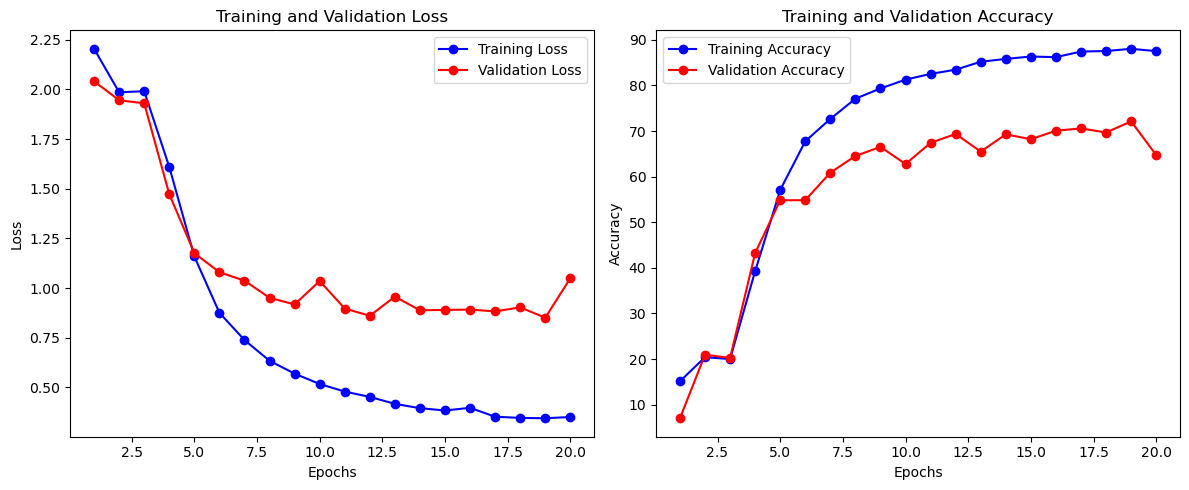

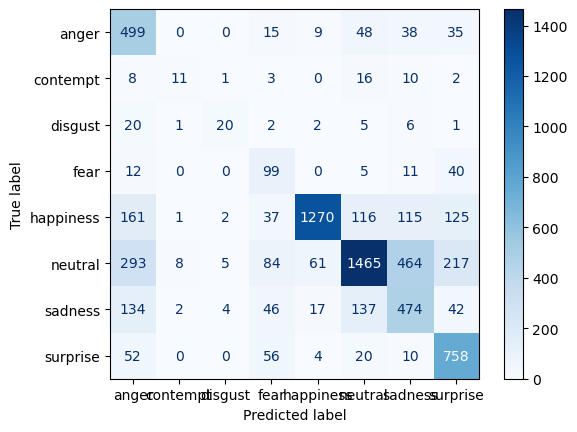

In [12]:
# Define loss function and optimizer
tiny_vgg_4block = TinyVGG4()
optimizer_4block = optim.Adam(tiny_vgg_4block.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_4block, val_losses_4block, train_accuracies_4block, val_accuracies_4block, all_preds_4block, all_labels_4block = train_model(tiny_vgg_4block,train_loader, test_loader,criterion, optimizer_4block, num_epochs)

plot_results(train_losses_4block, val_losses_4block, train_accuracies_4block, val_accuracies_4block, num_epochs, all_preds_4block, all_labels_4block)



In [5]:
# adding another convolutional layer block (total of 5 blocks)

class TinyVGG5(nn.Module):
    def __init__(self, num_classes):
        super(TinyVGG5, self).__init__()
        
        self.conv_layers = nn.Sequential(
            # Convolutional Layer Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128 -> 64

            # Convolutional Layer Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64 -> 32

            # Convolutional Layer Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32 -> 16

            # Convolutional Layer Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 16 -> 8

            # Convolutional Layer Block 5
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # 8 -> 4
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(512 * 4 * 4, 512), 
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x


Epoch 1/20, train Loss: 2.1244, train Acc: 13.64%, validation Loss: 2.0657, validation Acc: 36.58%
Epoch 2/20, train Loss: 1.9902, train Acc: 18.83%, validation Loss: 1.9212, validation Acc: 24.92%
Epoch 3/20, train Loss: 1.7762, train Acc: 28.73%, validation Loss: 1.9218, validation Acc: 26.79%
Epoch 4/20, train Loss: 1.3885, train Acc: 46.90%, validation Loss: 1.6677, validation Acc: 34.81%
Epoch 5/20, train Loss: 1.0278, train Acc: 61.66%, validation Loss: 1.3336, validation Acc: 50.84%
Epoch 6/20, train Loss: 0.8236, train Acc: 69.45%, validation Loss: 1.2366, validation Acc: 51.98%
Epoch 7/20, train Loss: 0.6721, train Acc: 75.29%, validation Loss: 1.0861, validation Acc: 60.59%
Epoch 8/20, train Loss: 0.5996, train Acc: 78.26%, validation Loss: 1.0340, validation Acc: 62.97%
Epoch 9/20, train Loss: 0.5232, train Acc: 81.23%, validation Loss: 0.9087, validation Acc: 68.22%
Epoch 10/20, train Loss: 0.4848, train Acc: 82.51%, validation Loss: 0.9357, validation Acc: 67.63%
Epoch 11/

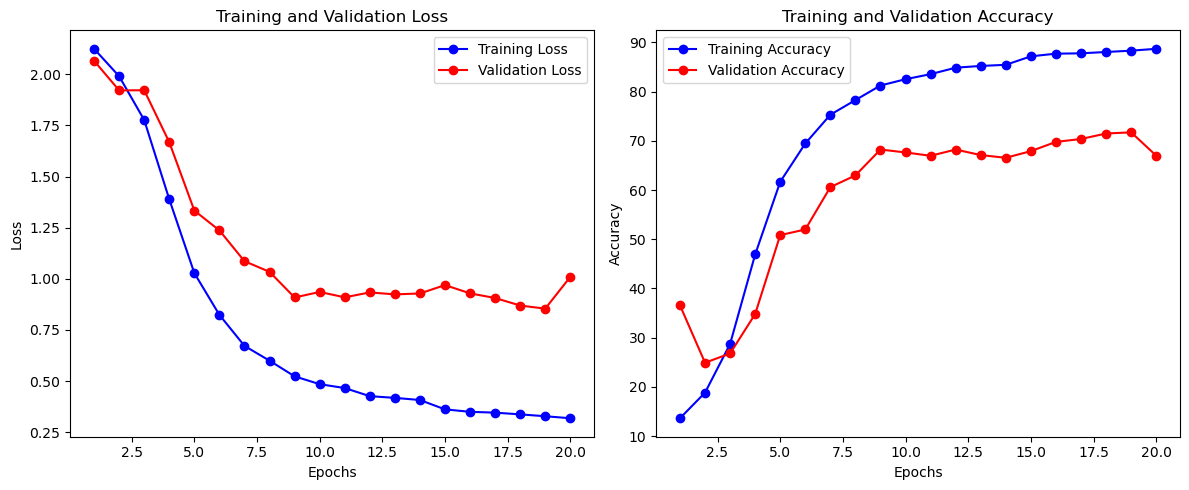

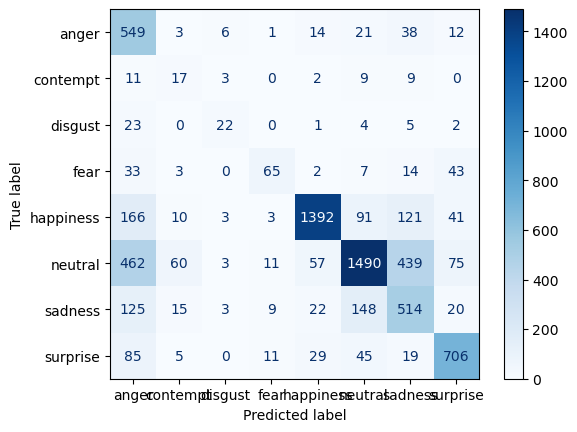

In [15]:

vgg_5block = TinyVGG5(num_classes=num_classes)
optimizer_5block = optim.Adam(vgg_5block.parameters(), lr=learning_rate,weight_decay=wd)

train_losses_5block, val_losses_5block, train_accuracies_5block, val_accuracies_5block, all_preds_5block, all_labels_5block = train_model(vgg_5block,train_loader, test_loader,criterion, optimizer_5block, num_epochs)

plot_results(train_losses_5block, val_losses_5block, train_accuracies_5block, val_accuracies_5block, num_epochs, all_preds_5block, all_labels_5block)

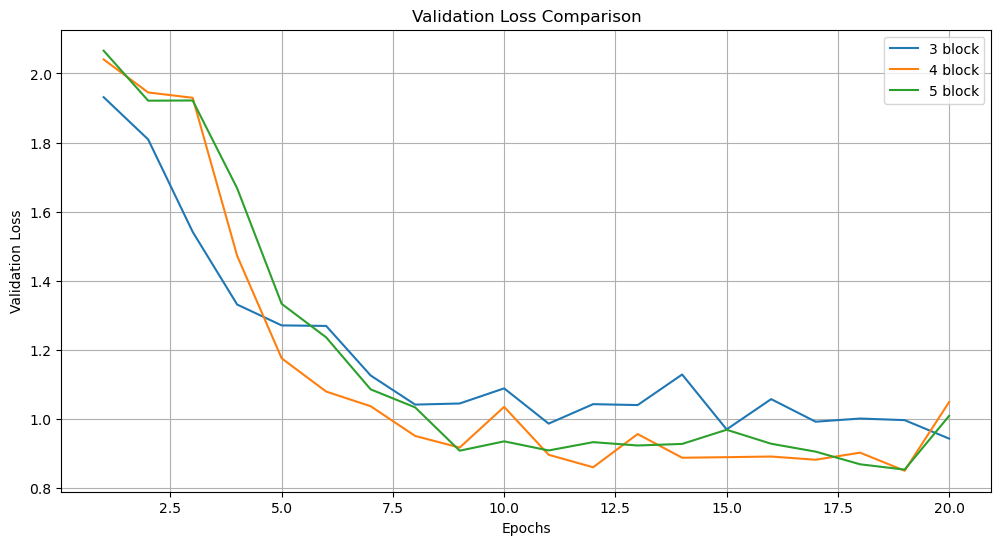

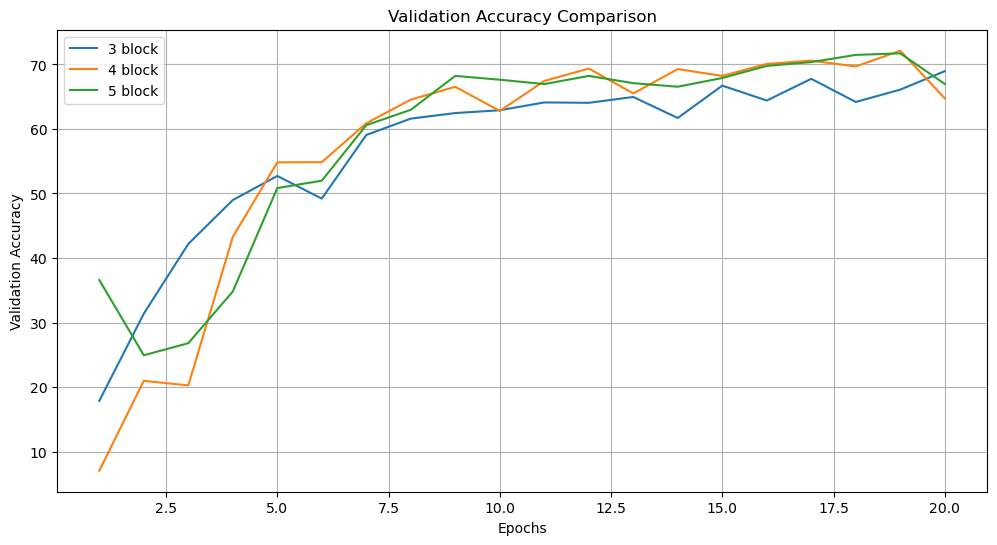

In [16]:
# comparing the validation loss and accuracy of the three models

epochs = range(1, num_epochs + 1)

# validation loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_losses, label='3 block')
plt.plot(epochs, val_losses_4block, label='4 block')
plt.plot(epochs, val_losses_5block, label='5 block')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, val_accuracies, label='3 block')
plt.plot(epochs, val_accuracies_4block, label='4 block')
plt.plot(epochs, val_accuracies_5block, label='5 block')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.show()

Model comparison

The model with 3 convolutional layer blocks performed  marginally worse than both the 4 and 5 block models at the end of the 20th epoch. While both the 4 and 5 block model performed similarly, the performance of the 5 block model was noticeably more stable with less fluctuations  between epochs.

Based on the above findings, The model with 5 convolutional layer blocks exhibits the most stable performance, and would thus respond the most predictably to hyper-parameter adjustments. Hence, hyper-parameter tuning will be performed with the 5block model

In [18]:
# hyper parameter tuning
from sklearn.model_selection import ParameterGrid

#base params:
#   lr = 0.001
#   batch = 32
#   optimizer  = adam
#   wd = 0.001

param_grid = {
    'lr': [0.01, 0.001, 0.0001],
    'batch_size': [32, 64],
    'optimizer': ['SGD', 'Adam'],
    'weight_decay': [0.0001, 0.001, 0.01]
}

best_params = None
best_val_accuracy = 0

for params in ParameterGrid(param_grid):
    print(params)
    # Initialize the model, criterion, and optimizer with the current hyperparameters
    model = TinyVGG5(num_classes=8) # choose model here
    if params['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    elif params['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
    
    # Update data loaders with the current batch size
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], sampler=sampler)
    val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # Train the model
    _, _, _, val_accuracies, _, _ = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

    # Get the best validation accuracy for the current hyperparameters
    max_val_accuracy = max(val_accuracies)
    if max_val_accuracy > best_val_accuracy:
        best_val_accuracy = max_val_accuracy
        best_params = params

print(f'Best Hyperparameters: {best_params}')
print(f'Best Validation Accuracy: {best_val_accuracy}')

{'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.0001}
Epoch 1/15, train Loss: 1.4897, train Acc: 43.81%, validation Loss: 1.6527, validation Acc: 43.94%
Epoch 2/15, train Loss: 0.8308, train Acc: 69.52%, validation Loss: 9.1022, validation Acc: 12.71%
Epoch 3/15, train Loss: 0.5774, train Acc: 78.93%, validation Loss: 1.0335, validation Acc: 66.66%
Epoch 4/15, train Loss: 0.4558, train Acc: 83.27%, validation Loss: 2.7691, validation Acc: 38.46%
Epoch 5/15, train Loss: 0.3655, train Acc: 86.80%, validation Loss: 1.9654, validation Acc: 53.20%
Epoch 6/15, train Loss: 0.3019, train Acc: 89.12%, validation Loss: 0.9337, validation Acc: 69.62%
Epoch 7/15, train Loss: 0.2522, train Acc: 91.16%, validation Loss: 0.9344, validation Acc: 70.81%
Epoch 8/15, train Loss: 0.2081, train Acc: 92.64%, validation Loss: 0.8891, validation Acc: 74.28%
Epoch 9/15, train Loss: 0.1716, train Acc: 94.06%, validation Loss: 4.8924, validation Acc: 29.10%
Epoch 10/15, train Loss: 0.1541, t

Based on the training output, the model with utilizing {'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.001} as its hyper parameters performed better than the other combinations by quite a significant margin. Hence, we train the model for an additional 5 epochs, for any potential gain in performance.

Epoch 1/20, train Loss: 1.4973, train Acc: 43.69%, validation Loss: 10.7885, validation Acc: 1.18%
Epoch 2/20, train Loss: 0.8375, train Acc: 69.66%, validation Loss: 22.4183, validation Acc: 0.86%
Epoch 3/20, train Loss: 0.6379, train Acc: 77.63%, validation Loss: 1.0233, validation Acc: 64.04%
Epoch 4/20, train Loss: 0.4496, train Acc: 83.77%, validation Loss: 3.6017, validation Acc: 55.95%
Epoch 5/20, train Loss: 0.4023, train Acc: 85.87%, validation Loss: 14.3137, validation Acc: 9.07%
Epoch 6/20, train Loss: 0.3382, train Acc: 88.30%, validation Loss: 0.8110, validation Acc: 73.45%
Epoch 7/20, train Loss: 0.2643, train Acc: 90.69%, validation Loss: 0.8847, validation Acc: 72.70%
Epoch 8/20, train Loss: 0.2255, train Acc: 92.15%, validation Loss: 0.8480, validation Acc: 74.50%
Epoch 9/20, train Loss: 0.1873, train Acc: 93.73%, validation Loss: 1.7039, validation Acc: 54.78%
Epoch 10/20, train Loss: 0.1613, train Acc: 94.53%, validation Loss: 1.8965, validation Acc: 51.94%
Epoch 11/

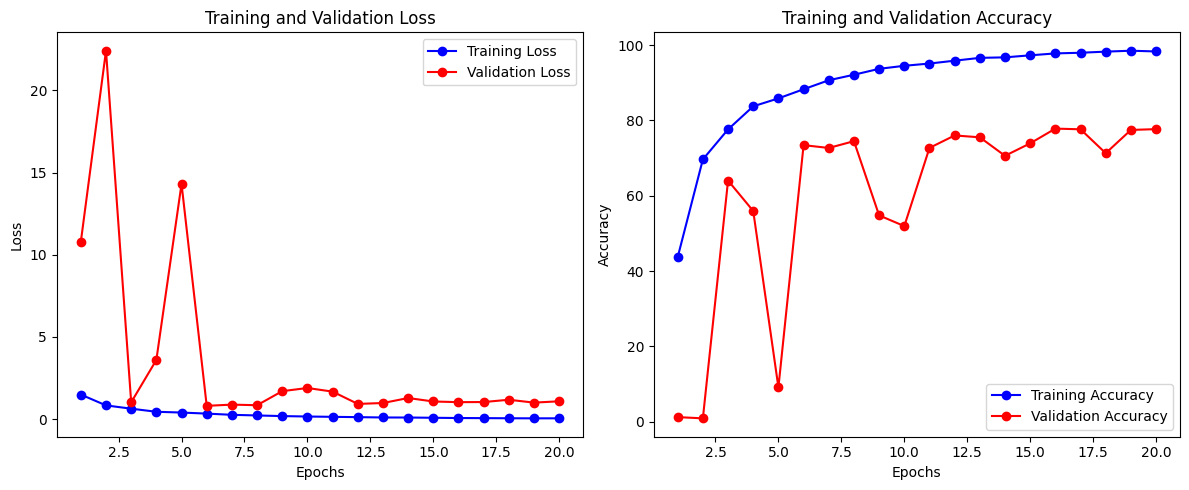

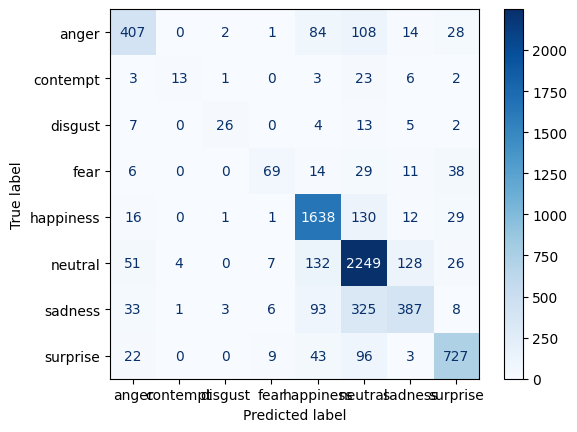

In [11]:
# Retrain the model with the best hyperparameters
best_params = {'batch_size': 32, 'lr': 0.01, 'optimizer': 'SGD', 'weight_decay': 0.001}
criterion = nn.CrossEntropyLoss()
model = TinyVGG5(num_classes=8) # choose model here

if best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
elif best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=best_params['batch_size'], sampler=sampler)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

train_losses, val_losses, train_accuracies, val_accuracies, all_preds, all_labels = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20)

plot_results(train_losses, val_losses, train_accuracies, val_accuracies, 20, all_preds, all_labels)


Given the model's very high training accuracy and low loss comapred to its fluctuating validaiton and loss, it is likely overfited. The initial fluctuations suggests a potential difficulty in finding meaningful features, but managed to stabilise after the 5th epoch achieving an accuracy of 77.70% at the end of the training cycle.

In [12]:
# save the model
torch.save(model.state_dict(), 'tiny_VGG.pth')

Accuracy of the network on the test images: 77.70%
Accuracy of anger: 63.20%
Accuracy of contempt: 25.49%
Accuracy of disgust: 45.61%
Accuracy of fear: 41.32%
Accuracy of happiness: 89.66%
Accuracy of neutral: 86.60%
Accuracy of sadness: 45.21%
Accuracy of surprise: 80.78%


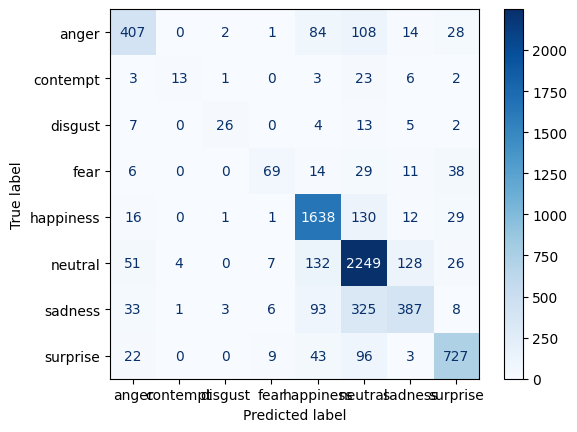

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Test the model (percentage of correct predictions)

num_classes = 8
model = TinyVGG5(num_classes)
model.load_state_dict(torch.load('tiny_VGG.pth'))
model = model.to(device)
model.eval()

num_classes = 8
model = TinyVGG5(num_classes)
model.load_state_dict(torch.load('tiny_vgg_best_model.pth'))
model = model.to(device)
model.eval()

correct = 0
total = 0

# Lists to store all labels and predictions for confusion matrix
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Append labels and predictions for confusion matrix
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

# Test the model (accuracy per class)
class_correct = list(0. for _ in range(num_classes))
class_total = list(0. for _ in range(num_classes))

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(num_classes):
    print(f'Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%')

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()